In [1]:
# !pip install scikit-optimize

In [2]:
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# Classifier 
import lightgbm as lgb 
import xgboost as xg 
from sklearn import svm

# Metrics 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_auc_score

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Labeling
from sklearn.preprocessing import OneHotEncoder

# Seacrh 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [3]:
train = pd.read_csv('/content/data/train.csv')
test = pd.read_csv('/content/data/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
train.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
train["Gender"].fillna(train["Gender"].mode()[0],inplace=True)
train["Married"].fillna(train["Married"].mode()[0],inplace=True)
train['Dependents'].fillna(train["Dependents"].mode()[0],inplace=True)
train["Self_Employed"].fillna(train["Self_Employed"].mode()[0],inplace=True)
train["Credit_History"].fillna(train["Credit_History"].mode()[0],inplace=True)
train["Loan_Amount_Term"].fillna(train["Loan_Amount_Term"].mode()[0],inplace=True)
train["LoanAmount"].fillna(train["LoanAmount"].median(),inplace=True)

In [8]:
train["TotalIncome"]=train["ApplicantIncome"]+train["CoapplicantIncome"]

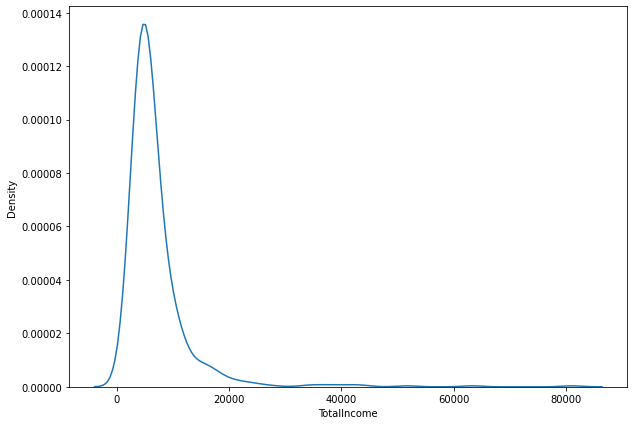

In [9]:
plt.figure(figsize=(10, 7))
sns.kdeplot(train["TotalIncome"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


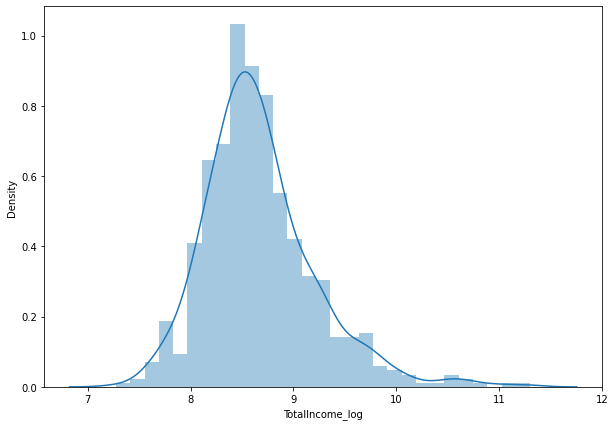

In [10]:
train["TotalIncome_log"]=np.log(train["TotalIncome"])

plt.figure(figsize=(10, 7))
sns.distplot(train["TotalIncome_log"])

In [11]:
train["EMI"]=train["LoanAmount"]/train["Loan_Amount_Term"]
train["Balance_Income"] = train["TotalIncome"]-train["EMI"]*1000 # To make the units equal we multiply with 1000

In [12]:
train=train.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term", "Loan_ID"],axis=1)

In [13]:
corr = train.corr()
# highest_corr_features = corr.index[abs(corr["Loan_Status"])>0.2]

In [14]:
# plt.figure(figsize=(10,10))
# sns.heatmap(corr, cmap='magma', annot=True)

In [15]:
cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status', 'Dependents']

In [16]:
for i, j in enumerate(cols):
  train[j] = train[j].astype('category').cat.codes

In [17]:
X = train.drop('Loan_Status', 1)
y = train.Loan_Status

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [18]:
df = pd.get_dummies(X)

In [19]:
df = df.loc[:, df.columns != 'Balance_Income']

In [20]:
ordered_rank_features = SelectKBest(score_func=chi2, k='all')
ordered_feature = ordered_rank_features.fit(df, y)

In [21]:
df_scores = pd.DataFrame(ordered_feature.scores_, columns=['Score'])
df_columns = pd.DataFrame(df.columns)
univariate_ranked = pd.concat([df_columns, df_scores],axis=1)
univariate_ranked.columns = ['Features', 'Scores']
univariate_ranked.set_index('Features', inplace = True)

# Ambil 5 fitur paling penting
top_cat = univariate_ranked.sort_values('Scores', ascending = False).head()

In [22]:
X = pd.get_dummies(X)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=7)

In [23]:
params_search = {
    'max_depth': Integer(1, 10),
    # 'bagging_freq': Integer(1, 40), 
    # 'bagging_fraction': Real(0.5, 0.99),
    'n_estimators': Integer(50, 1000),
    'learning_rate': Real(0.0001, 0.99),

    'boosting_type': Categorical(['dart', 'gbdt', 'goss']), 
    'objective': Categorical(['regression_l1', 'regression_l2', 'regression']),
  }
  
params = {
    'boosting_type':'gbdt', 
    'learning_rate' : 0.0496309207068068,
    'max_depth': 2, 
    'n_estimators': 111, 
    'objective': 'regression'
}

In [24]:
# %%time
# model = lgb.LGBMClassifier()
# model.fit(train_x, train_y)

# cv = KFold(n_splits=5)
# opt = BayesSearchCV(model, params_search, cv=cv, scoring='accuracy')
# opt.fit(train_x, train_y)

# cv_results = pd.DataFrame(opt.cv_results_)
# cv_results.to_csv('params.csv')

In [25]:
# cv_results = pd.read_csv('/content/params.csv')
# cv_results = cv_results.sort_values('rank_test_score', ascending=True)

In [26]:
# params = cv_results.iloc[-1]['params']
# cv_results.iloc[-1]['params']

In [27]:
def lgbm(train_x, test_x, train_y):
  model = lgb.LGBMClassifier(**params)
  model.fit(train_x, train_y)

  y_pred = model.predict(test_x)
  return y_pred

def xgb(train_x, test_x, train_y):
  model = xg.XGBClassifier()
  model.fit(train_x, train_y)

  y_pred = model.predict(test_x)
  return y_pred

def sv(train_x, test_x, train_y):
  model = svm.SVC()
  model.fit(train_x, train_y)

  y_pred = model.predict(test_x)
  return y_pred

In [28]:
def acc(y_test, y_pred):
  f1 = f1_score(y_test, y_pred)
  roc = roc_auc_score(y_test, y_pred)
  precission = precision_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)

  return f1, accuracy, precission, roc

In [29]:
dat = {
    'lgbm': lgbm(train_x, test_x, train_y), 
    'xgb': xgb(train_x, test_x, train_y), 
    'svm': sv(train_x, test_x, train_y)}

In [30]:
result = pd.DataFrame(data=dat)

In [31]:
f1, accuracy, precission, roc = acc(test_y, result.lgbm)
print('Test F1: %.8f' % f1)
print('Test Accuracy: %.8f' % accuracy)
print('Test Precission: %.8f' % precission)
print('Test ROC AUC: %.8f' % roc)
print('\n')

Test F1: 0.87050360
Test Accuracy: 0.80540541
Test Precission: 0.78571429
Test ROC AUC: 0.71741142




In [32]:
f1, accuracy, precission, roc = acc(test_y, result.xgb)
print('Test F1: %.8f' % f1)
print('Test Accuracy: %.8f' % accuracy)
print('Test Precission: %.8f' % precission)
print('Test ROC AUC: %.8f' % roc)
print('\n')

Test F1: 0.85714286
Test Accuracy: 0.78918919
Test Precission: 0.78523490
Test ROC AUC: 0.70947911




In [33]:
f1, accuracy, precission, roc = acc(test_y, result.svm)
print('Test F1: %.8f' % f1)
print('Test Accuracy: %.8f' % accuracy)
print('Test Precission: %.8f' % precission)
print('Test ROC AUC: %.8f' % roc)
print('\n')

Test F1: 0.79870130
Test Accuracy: 0.66486486
Test Precission: 0.66847826
Test ROC AUC: 0.49596774


